Tom Barclay's xoflares on EPIC-246301900

In [21]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from lightkurve import search
import theano
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess
import theano.tensor as tt
from scipy.signal import savgol_filter
from pymc3.step_methods.hmc import quadpotential
import corner
import pandas as pd

In [2]:
print(xo.__version__)
print(theano.__version__)
print(pm.__version__)
print(lk.__version__)

0.4.4
1.0.4
3.9.3
2.0.3


In [ ]:
"""
lc = search.search_targetpixelfile('EPIC 246301900').download()
lc.to_lightcurve().plot()
ref_time = 0.5 * (lc.time.min() + lc.time.max())
"""

In [4]:
"""lc = lc.to_lightcurve()
print(lc.flux.shape)
"""

(3379,)


In [3]:
from astropy.io import fits
filename = '/Users/chris/Desktop/superflares/ktwo246301900-c12_llc.fits'
hdul = fits.open(filename)
hdul.info()

Filename: /Users/chris/Desktop/superflares/ktwo246301900-c12_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   ()      
  1  LIGHTCURVE    1 BinTableHDU    155   3862R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        48   (10, 8)   int32   


In [4]:
data = fits.getdata(filename,header=True,ext=1)
lc = pd.DataFrame(np.array(data[0]).byteswap().newbyteorder()) # to avoid big-endian/little-endian mixup: https://stackoverflow.com/questions/30283836/creating-pandas-dataframe-from-numpy-array-leads-to-strange-errors
print(lc.head())

          TIME  TIMECORR  CADENCENO     SAP_FLUX  SAP_FLUX_ERR       SAP_BKG  \
0  2905.377230  0.005332     136855  614164.8125     22.716827  19529.195312   
1  2905.397662  0.005331     136856  614196.0000     22.708811  19530.005859   
2  2905.418095  0.005329     136857  614179.6250     22.713530  19541.736328   
3  2905.438527  0.005328     136858  614099.5000     22.717106  19533.994141   
4  2905.458959  0.005327     136859  614238.1875     22.723835  19532.445312   

   SAP_BKG_ERR  PDCSAP_FLUX  PDCSAP_FLUX_ERR  SAP_QUALITY  PSF_CENTR1  \
0     7.201994          NaN              NaN       524288         NaN   
1     7.175916  612915.2500        22.353420            0         NaN   
2     7.180060  612892.8125        22.366695            0         NaN   
3     7.191803  612824.8125        22.378389            0         NaN   
4     7.191343  612975.3750        22.391329            0         NaN   

   PSF_CENTR1_ERR  PSF_CENTR2  PSF_CENTR2_ERR  MOM_CENTR1  MOM_CENTR1_ERR  \
0  

In [5]:
### PREP

# divide data into pre-flare, post-flare/pre-gap, and post-flare/post-gap
lc = lc.dropna(subset=['TIME','PDCSAP_FLUX','PDCSAP_FLUX_ERR']) # toss NaNs since they'll create matrices of NaNs
print(len(lc))

pre = lc.loc[:1611] # next record is the beginning of the flare, so stop here
post = lc.loc[1614:2336] # start from after the flare until beginning of the gap in time series data
postgap = lc.loc[2337:] # start from end of the gap in data until end of time series data

# calculate reference (average) time
def calculate_ref_time(lc):
    return 0.5 * (np.min(lc.TIME) + np.max(lc.TIME))

# calculate normalized flux
def normalize_flux(lc):
    return (lc/np.median(lc)) - 1

3255


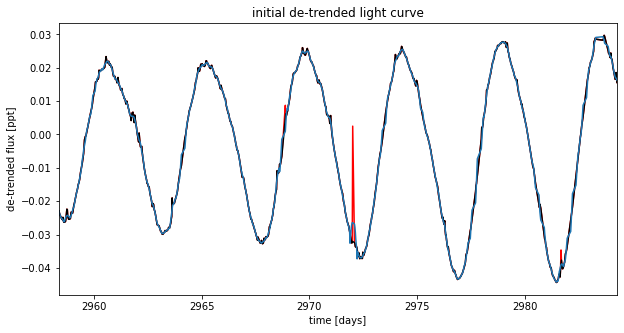

In [6]:
# get a smoothed version of the light curve
norm_y = normalize_flux(postgap.PDCSAP_FLUX)
smooth = savgol_filter(norm_y, 13, polyorder=3)
resid = norm_y - smooth
mask = resid < 3.5*np.sqrt(np.mean(resid**2))

plt.figure(figsize=(10, 5))
plt.plot(postgap.TIME, norm_y, "r")
plt.plot(postgap.TIME[mask], norm_y[mask], "k")
plt.plot(postgap.TIME, smooth)
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
#plt.ylim(580000, 680000)
plt.xlim(postgap.TIME.min(), postgap.TIME.max());

In [7]:
def find_flares(lc):

    # find some flares
    mflare = resid < 3.5 * np.sqrt(np.mean(resid**2))
    lc.CADENCENO = lc.CADENCENO
    cads = lc.CADENCENO - list(lc.CADENCENO)[0] # index at 0
    ref_time = calculate_ref_time(lc)
    x = lc.TIME - ref_time # subtract time by average time
    y = resid # data with savgol subtracted

    fidx = cads.loc[~mflare][:-1]#[np.diff(cads[~mflare]) < 1]
    fidx = list(fidx) # address indexing errors
    npts = np.array([])
    i = 0
    n = 1
    while True:
        try:
            if fidx[i + 1] == fidx[i] + n:
                # measure flare: keep track of number of points (fatness) of a flare
                fidx = np.delete(fidx, i + 1)
                n += 1
            else:
                # count flare: concatenate to array, advance, and reset count
                npts = np.r_[npts, n+1] 
                i += 1
                n = 1
        except IndexError:
            npts = np.r_[npts, n+1]
            break
    tpeaks = np.array([x.loc[(lc.CADENCENO - list(lc.CADENCENO)[0]) == fidx[i]] for i in range(len(fidx))]).T[0]
    ampls = np.array([resid.loc[(lc.CADENCENO - list(lc.CADENCENO)[0]) == fidx[i]] for i in range(len(fidx))]).T[0]
    fwhms = np.asarray(npts) * (2/1440)
    npeaks = np.shape(tpeaks)[0]
    print(tpeaks, ampls, fwhms, npeaks)
    return x, y, tpeaks, ampls, fwhms, npeaks

x, y, tpeaks, ampls, fwhms, npeaks = find_flares(postgap)

[-2.44161407  0.68441788] [0.00782076 0.02894517] [0.00277778 0.00277778] 2


/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
"""# get a smoothed version of the light curve
smooth = savgol_filter(lc.flux, 13, polyorder=3)
resid = lc.flux - smooth
mask = resid < 2*np.sqrt(np.mean(resid**2))

plt.figure(figsize=(10, 5))
plt.plot(lc.time, lc.flux, "r")
plt.plot(lc.time[mask], lc.flux[mask], "k")
plt.plot(lc.time, smooth)
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.ylim(580000, 680000)
plt.xlim(lc.time.min(), lc.time.max());
"""

**Check if times of predicted flares match up**

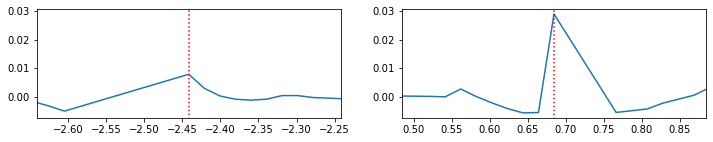

In [8]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
for i in range(npeaks):
    ax = axes[i]
    ax.plot(x, y)
    #ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
    ax.axvline(tpeaks[i], -1, 1, color='r', linestyle=':')
    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
    #ax.set_ylim(np.min(y), np.max(ampls[i]+3))

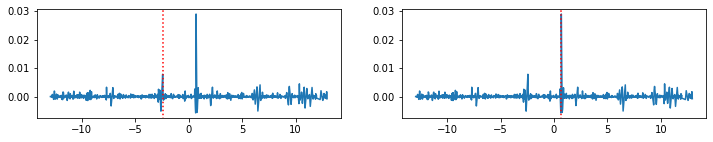

In [9]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
for i in range(npeaks):
    ax = axes[i]
    ax.plot(x, y)
    #ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
    ax.axvline(tpeaks[i], -1, 1, color='r', linestyle=':')


In [10]:
# this is the flare model implemented in theano
def get_light_curve(time, tpeaks, fwhms, ampls, texp=None, oversample=7):
    time = time.astype('float64')
    time = tt.as_tensor_variable(time)
    
    if texp is None:
        tgrid = time
    if texp is not None:
        # taking this oversample code from
        # https://github.com/dfm/exoplanet
        # and https://github.com/lkreidberg/batman
        oversample = int(oversample)
        oversample += 1 - oversample % 2
        dt = np.linspace(-texp / 2., texp / 2.,
                         oversample)
        tgrid = tt.shape_padright(time) + dt
        
    multiflare_lc = multiflaremodel(tgrid, tpeaks, fwhms, ampls)
    
    if texp is not None:
        multiflare_lc = tt.mean(tt.reshape(multiflare_lc, (-1, oversample)),
            axis=1)

    return multiflare_lc

def multiflaremodel(t, tpeaks, fwhms, ampls):
    t = t.astype('float64')
    t = tt.as_tensor_variable(t)
    multiflare_lc = tt.zeros_like(t)
    flare_lc = tt.zeros_like(t)
    
    def scan_func(tpeak, fwhm, ampl):
        zeropad_flare_lc = tt.zeros_like(t)
        tcut = (((t - tpeak)/fwhm > -1.) * ((t - tpeak)/fwhm < 20.)).nonzero()
        flare_lc = _flaremodel(t[tcut], tpeak, fwhm, ampl)
        zeropad_flare_lc = tt.set_subtensor(zeropad_flare_lc[tcut],  flare_lc)
        return zeropad_flare_lc
    
    components, updates = theano.scan(fn=scan_func,
                                      sequences=[tpeaks, fwhms, ampls],
                                      )
    multiflare_lc = tt.sum(components, axis=0)
    
#     for i in range(npeaks):
#         tcut = (((t - tpeaks[i])/fwhms[i] > -1.) * ((t - tpeaks[i])/fwhms[i] < 20.)).nonzero()
#         flare_lc = _flaremodel(t[tcut], tpeaks[i], fwhms[i], ampls[i])
#         multiflare_lc = tt.set_subtensor(multiflare_lc[tcut],  multiflare_lc[tcut] + flare_lc)
    return multiflare_lc

def _flaremodel(t, tpeak, fwhm, ampl):
    # reuses some code from AltaiPony and Apaloosa
    t = tt.as_tensor_variable(t)
    flare_lc = tt.zeros_like(t)
    flare_lc = tt.where((t <= tpeak) * ((t - tpeak)/fwhm > -1.),
                        before_flare(t, tpeak, fwhm, ampl),
                        flare_lc
                       )
    flare_lc = tt.where((t > tpeak) * ((t - tpeak)/fwhm < 20.),
                        after_flare(t, tpeak, fwhm, ampl),
                        flare_lc
                       )
    return flare_lc

def before_flare(t, tpeak, fwhm, ampl):
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    fout = ((_fr[0] + _fr[1] * ((t - tpeak) / fwhm) +
                        _fr[2] * ((t - tpeak) / fwhm)**2. +
                        _fr[3] * ((t - tpeak) / fwhm)**3. +
                        _fr[4] * ((t - tpeak) / fwhm)**4. ) *
                        ampl)
    return fout

def after_flare(t, tpeak, fwhm, ampl):
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]
    fout = ((_fd[0] * tt.exp( ((t - tpeak) / fwhm) * _fd[1]) +
             _fd[2] * tt.exp( ((t - tpeak) / fwhm) * _fd[3] )) *
            ampl)
    return fout

xx = tt.dvector('xx')
tpeaksx = tt.dvector('tpeaksx')
fwhmsx = tt.dvector('fwhmsx')
amplsx = tt.dvector('amplsx')
#texp = 0.001388888888888889
#multiflare = theano.function([xx, tpeaksx, fwhmsx, amplsx],
#                    get_light_curve(xx, tpeaksx, fwhmsx, amplsx, texp=texp))
multiflare = theano.function([xx, tpeaksx, fwhmsx, amplsx],
                    get_light_curve(xx, tpeaksx, fwhmsx, amplsx))



In [11]:
# with pm.Model() as model:
#     mean = pm.Normal("mean", mu=0, sd=3.0)
#     logs2 = pm.Normal("logs2", mu=np.log(np.var(y)), sd=5.0)
    
#     tpeak = pm.Normal("tpeak", mu=tpeaks, sd=np.ones_like(tpeaks) * 0.05,
#                       testval=tpeaks, shape=npeaks)
#     logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms), sd=3.0, testval=np.log(0.001), shape=npeaks)
#     logAmpl = pm.Normal("logAmpl", mu=np.log(ampls), sd=3.0, testval=np.log(10*np.var(y)), shape=npeaks)
    
#     fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
#     ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
    
#     flare_lc = multiflaremodel(x, tpeak, fwhm, ampl, npeaks=npeaks)
#     pm.Deterministic("flare_lc", flare_lc)
#     pm.Normal("obs", mu=flare_lc + mean, sd=tt.exp(2*logs2), observed=y)
    
#     map_soln = pm.find_MAP(start=model.test_point, vars=[fwhm, mean])
#     map_soln = pm.find_MAP(start=map_soln, vars=[ampl, mean])
#     map_soln = pm.find_MAP(start=map_soln, vars=[fwhm, ampl])
#     map_soln = pm.find_MAP(start=map_soln, vars=[tpeak])

with pm.Model() as model:
    npeaks = np.shape(tpeaks)[0]
    mean = pm.Normal("mean", mu=0, sd=3.0, testval=0)
    logs2 = pm.Normal("logs2", mu=np.log(np.var(y)), sd=2.0)
    
    tpeak = pm.Normal("tpeak", mu=tpeaks, sd=np.ones_like(tpeaks) * 0.003,
                      testval=tpeaks, shape=npeaks)
    logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms), sd=1.0, testval=np.log(fwhms),
                        shape=npeaks)
    logAmpl = pm.Normal("logAmpl", mu=np.log(ampls), sd=1.0, testval=np.log(ampls),
                        shape=npeaks)
    
    fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
    ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
    
    #flare_lc = get_light_curve(x, tpeak, fwhm, ampl, texp=texp, oversample=15)
    flare_lc = get_light_curve(x, tpeak, fwhm, ampl, oversample=15)
    pm.Deterministic("flare_lc", flare_lc)
    pm.Normal("obs", mu=flare_lc + mean, sd=tt.exp(2*logs2), observed=y)
    
    map_soln = xo.optimize(start=model.test_point, vars=[fwhm, mean])
    map_soln = xo.optimize(start=map_soln, vars=[ampl, mean])
    map_soln = xo.optimize(start=map_soln, vars=[fwhm, ampl])
    map_soln = xo.optimize(start=map_soln, vars=[tpeak])
    
    approx = pm.MeanField(start=map_soln)
    pm.fit(method=pm.KLqp(approx), n=200000,
            obj_optimizer=pm.adagrad_window
        )
    start = approx.sample(draws=4, )
    start = list(start)
    stds = approx.bij.rmap(approx.std.eval())
    cov = model.dict_to_array(stds) ** 2
    potential = quadpotential.QuadPotentialDiag(cov)

optimizing logp for variables: [mean, logFwhm]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -6.340233313352228e+19 -> -6.305277339420753e+19
optimizing logp for variables: [mean, logAmpl]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -6.305277339420753e+19 -> -6.3050070943757476e+19
optimizing logp for variables: [logAmpl, logFwhm]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -6.3050070943757476e+19 -> -6.304999379065788e+19
optimizing logp for variables: [tpeak]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -6.304999379065788e+19 -> -6.304999379065788e+19


Finished [100%]: Average Loss = -5,967.9


In [12]:
start[0]['tpeak'] - 0.2

array([-2.6436665 ,  0.48492329])

/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


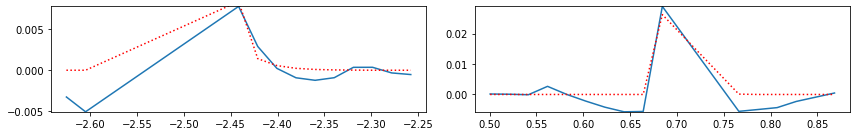

In [13]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
tps = start[0]['tpeak']
for i in range(npeaks):
    timemask = (x >= tps[i]-0.2) * (x < tps[i]+0.2) # true for values within +/- 0.2 of peak indices
    ax = axes[i]
    ax.plot(x[timemask], y[timemask])
    ax.plot(x[timemask], start[0]['flare_lc'][timemask], ':r')
    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
    ax.set_ylim(np.min(y[timemask]), np.max(y[timemask]))
fig.tight_layout()

#fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
#axes = axes.flatten()
#for i in range(npeaks):
#    ax = axes[i]
#    ax.plot(x, y)
#    ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
#    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
#    ax.set_ylim(np.min(y), np.max(ampls[i]+3))

In [14]:
# sampler = xo.PyMC3Sampler(window=200, start=0, finish=800)
# with model:
#     burnin = sampler.tune(tune=4000, start=map_soln, step_kwargs=dict(target_accept=0.9), init='advi_map')

In [15]:
# with model:
#     trace = sampler.sample(draws=2000)

with model:
    step = pm.NUTS(potential=potential, target_accept=0.9)
    trace = pm.sample(draws=2400, tune=200, step=step, start=start, cores=4)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logAmpl, logFwhm, tpeak, logs2, mean]


Sampling 4 chains for 200 tune and 2_400 draw iterations (800 + 9_600 draws total) took 562 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8127197480225163, but should be close to 0.9. Try to increase the number of tuning steps.
There were 270 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6787214973448812, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [16]:
pm.summary(trace, varnames= ['logAmpl', 'logFwhm', 'tpeak', 'logs2', 'mean'], )

/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pymc3/stats/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
logAmpl[0],-4.162,0.503,-4.860,-3.056,0.104,0.075,23.0,23.0,31.0,13.0,1.10
logAmpl[1],-2.815,0.515,-3.537,-1.912,0.078,0.056,43.0,43.0,56.0,505.0,1.06
logFwhm[0],-5.235,0.411,-5.913,-4.462,0.046,0.034,79.0,75.0,75.0,837.0,1.05
logFwhm[1],-6.072,0.567,-7.165,-5.225,0.032,0.024,312.0,278.0,489.0,232.0,1.01
tpeak[0],-2.442,0.002,-2.447,-2.439,0.000,0.000,371.0,371.0,350.0,2285.0,1.02
tpeak[1],0.683,0.002,0.680,0.685,0.000,0.000,45.0,45.0,80.0,234.0,1.07
logs2,-3.530,0.011,-3.549,-3.508,0.001,0.000,285.0,285.0,302.0,689.0,1.01
mean,-0.000,0.000,-0.000,0.000,0.000,0.000,637.0,484.0,655.0,381.0,1.01


/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


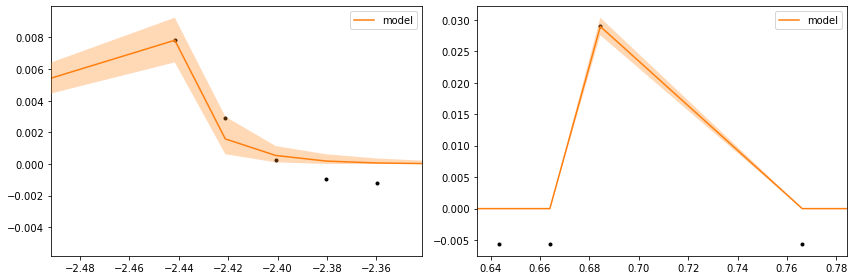

In [19]:
flc =  np.percentile(trace['flare_lc'], [5, 50, 95], axis=0)
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks*2])
axes = axes.flatten()
for i in range(npeaks):
    timemask = (x >= tpeaks[i]-0.2) * (x < tpeaks[i]+0.2)
    ax = axes[i]
    ax.plot(x[timemask], y[timemask], '.k')
    ax.plot(x[timemask], flc[1][timemask], color="C1", label="model")
    art = ax.fill_between(x[timemask], flc[0][timemask],
                          flc[2][timemask], color="C1", alpha=0.3,
                               zorder=1000)
    art.set_edgecolor("none")
    ax.set_xlim(tpeaks[i]-0.05, tpeaks[i]+0.1)
    #ax.set_ylim(np.min(y[timemask]) - 1, 1 + np.max(y[timemask]))
    ax.legend()
    
fig.tight_layout()
fig.savefig('flare-model-postflare-postgap.png')

In [17]:
# save out to combine with other two set of flares
#pd.Series(flc[1]).to_csv('post-flare-post-gap-flares.csv', index=False)

In [20]:
# for some reason, pymc wants to access trace at index 0 when trace starts at 1...so I cheat to make this work
trace._straces[0] = trace._straces[1]

IndexError: index 2 is out of bounds for axis 0 with size 2

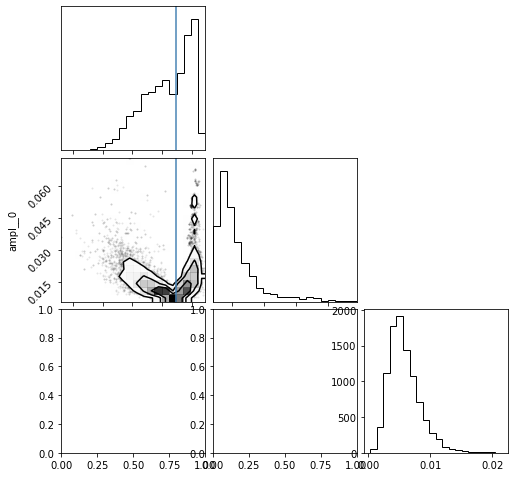

In [19]:
samples = pm.trace_to_dataframe(trace, varnames=['tpeak', 'ampl', 'fwhm'])
for i in range(trace['tpeak'].shape[1]):
    corner.corner(samples.loc[:,
                              ['tpeak__{}'.format(i), 'ampl__{}'.format(i),
                               'fwhm__{}'.format(i)]], truths=tpeaks);

In [20]:
print(samples.head())
print(trace['tpeak'].shape[1])
print(['tpeak__{}'.format(i), 'ampl__{}'.format(i), 'fwhm__{}'.format(i)])

   tpeak__0  tpeak__1   ampl__0   ampl__1   fwhm__0   fwhm__1
0 -2.444598  0.685427  0.014907  0.098470  0.005052  0.002450
1 -2.444538  0.685581  0.012191  0.096603  0.008018  0.002819
2 -2.442490  0.685307  0.009114  0.059551  0.003601  0.003190
3 -2.444223  0.685145  0.014528  0.059883  0.004456  0.002699
4 -2.444038  0.684997  0.012133  0.054911  0.005974  0.002196
2
['tpeak__0', 'ampl__0', 'fwhm__0']


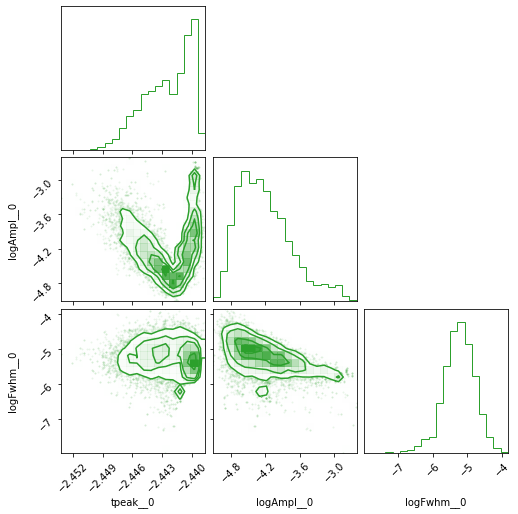

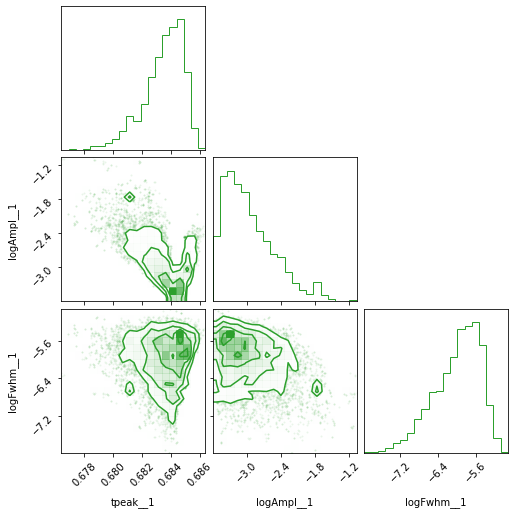

In [21]:
samples = pm.trace_to_dataframe(trace, varnames=['tpeak', 'logAmpl', 'logFwhm'])
for i in range(trace['tpeak'].shape[1]):
    corner.corner(samples.loc[:,
                              ['tpeak__{}'.format(i), 'logAmpl__{}'.format(i),
                               'logFwhm__{}'.format(i)]], color='C2');

### Flare energies

In [34]:
# get equivalent durations
ed_model = []
for i in range(npeaks):
    timemask = (x >= tpeaks[i]-0.2) & (x < tpeaks[i]+0.2)
    ed_model.append(np.trapz(flc[1][timemask]*86400, x[timemask]))
    
print(ed_model)

[66.57537330455135, 127.69311355527473]


In [35]:
def calculate_energy(kp, zeropoint, ed_model):
    l_sun = 3.0128e28 * 1e7 # Watts * 1e7 erg/s per Watt
    parallax = 21.6345 # in milliarcsecs (mas)
    distance = 22.74 # 46.22
    distance = 1./(parallax*0.001) # parsecs
    print(distance)
    pre_lkp = l_sun * np.power(10, 0.4*(zeropoint-kp)) # https://iopscience.iop.org/article/10.1088/0004-637X/797/2/121/pdf
    print("log pre LKp: ", np.log10(pre_lkp)) # log erg/(s*cm^2)
    lkp = (4*np.pi*distance**2) * pre_lkp * 4000
    print("log LKp: ", np.log10(lkp))
    print("ED: ", ed_model)
    try:
        return np.log10(lkp*ed_model)
    except:
        return np.log10([lkp*ed for ed in ed_model]) # show order of energy in ergs

# use kepmag value from exofop: https://exofop.ipac.caltech.edu/k2/edit_target.php?id=246301900
flare_energies = calculate_energy(kp=10.807, zeropoint=-20.24, ed_model=ed_model)
print("log flare energy: ", flare_energies)

46.22246874205551
log pre LKp:  23.060170302672592
log LKp:  31.09114643288431
ED:  [66.57537330455135, 127.69311355527473]
log flare energy:  [32.91446004 33.19731391]


### Subtract flare light curve

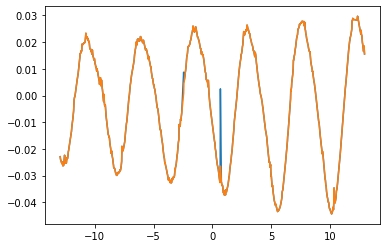

In [22]:
gp_mean = norm_y-flc[1] # mean for GP for total light curve fit is observed light curve - flare light curve
plt.plot(x, norm_y)
plt.plot(x, norm_y-flc[1])
#plt.plot(x, flc[1])
plt.show()

{'index': 123, 'log_power': -8.41554849094274, 'period': 4.565821917774273, 'period_uncert': 0.34604296835442233}


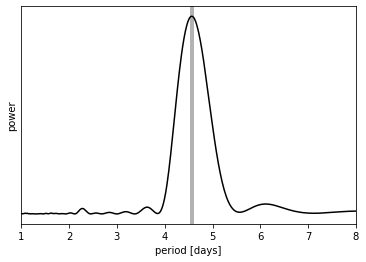

In [23]:
# periodogram
results = xo.estimators.lomb_scargle_estimator(
    x, gp_mean, max_peaks=1, min_period=1.0, max_period=8.0, samples_per_peak=50 # replaced y with gp_mean
)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(1 / freq, power, "k")
plt.axvline(peak["period"], color="k", lw=4, alpha=0.3)
plt.xlim((1 / freq).min(), (1 / freq).max())
plt.yticks([])
plt.xlabel("period [days]")
_ = plt.ylabel("power")
print(peak)

### Model flare-subtracted light curve with pyMC3 and GP likelihood

In [24]:
# get a smoothed version of the light curve
norm_y = normalize_flux(postgap.PDCSAP_FLUX)
norm_yerr = normalize_flux(postgap.PDCSAP_FLUX_ERR)
print(norm_y)
print(norm_yerr) # how to deal with errors in normalized time series? 

2594   -0.022913
2595   -0.023527
2596   -0.024082
2597   -0.024281
2598   -0.024571
          ...   
3856    0.017221
3857    0.016522
3859    0.018569
3860    0.016874
3861    0.015584
Name: PDCSAP_FLUX, Length: 1071, dtype: float32
2594   -0.016280
2595   -0.016569
2596   -0.016873
2597   -0.016956
2598   -0.016995
          ...   
3856    0.023091
3857    0.022657
3859    0.023501
3860    0.022514
3861    0.022021
Name: PDCSAP_FLUX_ERR, Length: 1071, dtype: float32


In [26]:
# okay, I got the period to work out. How about I don't fit every little spike now with my GP? 
# It works!! Hell yeah.
with pm.Model() as model:

    # The mean flux of the time series
    mean = pm.Normal("mean", mu=np.mean(gp_mean), sd=np.std(gp_mean)) # replaced 0.0 and 10.0
    # A jitter term describing excess white noise
    jitter = pm.Lognormal("jitter", mu=np.log(np.mean(norm_yerr)), sd=np.log(np.std(norm_yerr))) # try not logging
    #jitter = pm.Lognormal("jitter", mu=0., sd=np.std(norm_yerr))
    
    # A term to describe the non-periodic variability
    #sigma = pm.InverseGamma(
    #    "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0))
    #rho = pm.InverseGamma(
    #    "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0))
    sigma = pm.InverseGamma(
        "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 2.5))
    rho = pm.InverseGamma(
        "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 1.5))
    
    # The parameters of the RotationTerm kernel
    sigma_rot = pm.InverseGamma(
        "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 2.0)) # formerly Beta param was 5.0, not 2.0
    
    #period = pm.Lognormal("period", mu=np.log(peak["period"]), sd=1.0) 
    period = pm.Normal("period", mu=peak["period"], sd=1.0)  

    #Q0 = pm.Lognormal("Q0", mu=0, sd=2) # or np.log(np.mean(gp_mean))?  
    #dQ = pm.Lognormal("dQ", mu=0, sd=2) # or np.log(np.mean(gp_mean))?
    Q0 = pm.Lognormal("Q0", mu=0, sd=2) # or np.log(np.mean(gp_mean))?  
    dQ = pm.Lognormal("dQ", mu=0, sd=2) # or np.log(np.mean(gp_mean))?
    f = pm.Uniform("f", lower=0.1, upper=1.0)
    
    # Set up the Gaussian Process model
    kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q=1 / 3.0) # tweaking rho and sigma affects whether I'm touch-tight
    kernel += terms.RotationTerm(
        sigma=sigma_rot, period=period, Q0=Q0, dQ=dQ, f=f)
    gp = GaussianProcess(
        kernel, t=x, mean=mean, 
        diag=np.asarray(norm_yerr**2)+jitter**2, quiet=True) # diag = norm_yerr**2 + jitter**2

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=norm_y)

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict(norm_y))

    # Optimize to find the maximum a posteriori parameters
    map_soln = pmx.optimize()

optimizing logp for variables: [f, dQ, Q0, period, sigma_rot, rho, sigma, jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 898.1720987293585 -> 4176.720334360162


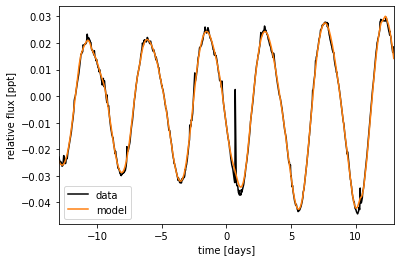

In [27]:
# plot maximum a posteriori model prediction

plt.plot(x, norm_y, "k", label="data")
plt.plot(x, map_soln["pred"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
#_ = plt.title("pyMC model of EPIC 246301900 light curve")
plt.savefig('quiescent_gp_postgap.png')
plt.show()

In [28]:
# sample from posterior
np.random.seed(10863087)
with model:
    trace = pmx.sample(
        tune=2500,
        draws=2500,
        start=map_soln,
        cores=2,
        chains=2,
        target_accept=0.95,
    )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f, dQ, Q0, period, sigma_rot, rho, sigma, jitter, mean]


Sampling 2 chains for 2_500 tune and 2_500 draw iterations (5_000 + 5_000 draws total) took 552 seconds.


In [29]:
with model:
    summary = pm.summary(
        trace,
        var_names=[
            "f",
            "dQ",
            "Q0",
            "period",
            "sigma_rot",
            "rho",
            "sigma",
            "jitter",
            "mean",
        ],
    )
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
f,0.299,0.223,0.100,0.784,0.004,0.003,3560.0,3026.0,4520.0,3289.0,1.0
dQ,7.410,27.085,0.000,25.857,0.452,0.320,3590.0,3590.0,5126.0,3535.0,1.0
Q0,26144.971,26307.699,2006.131,65947.217,486.392,343.965,2925.0,2925.0,4148.0,2928.0,1.0
period,8.968,0.270,8.476,9.487,0.004,0.003,3600.0,3600.0,3936.0,2853.0,1.0
sigma_rot,1.171,0.158,0.872,1.460,0.002,0.002,5100.0,4777.0,5426.0,3526.0,1.0
rho,134.919,22.871,95.151,177.315,0.401,0.284,3248.0,3248.0,3381.0,3078.0,1.0
sigma,0.998,0.161,0.712,1.296,0.002,0.002,4986.0,4689.0,5247.0,3599.0,1.0
jitter,0.000,0.000,0.000,0.000,0.000,0.000,1249.0,1249.0,1454.0,565.0,1.0
mean,-0.003,0.021,-0.044,0.034,0.000,0.000,5546.0,2860.0,5546.0,3668.0,1.0


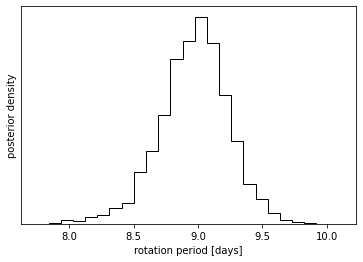

In [30]:
period_samples = trace["period"]
plt.hist(period_samples, 25, histtype="step", color="k", density=True)
plt.yticks([])
plt.xlabel("rotation period [days]")
_ = plt.ylabel("posterior density")
plt.savefig("period_posterior_postgap.png")

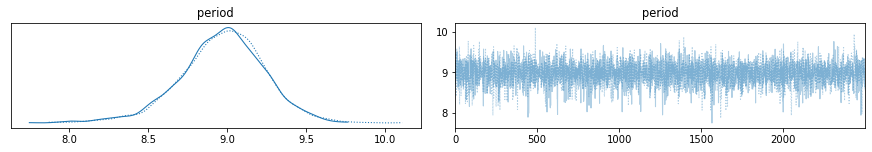

In [31]:
# show burn-in
import arviz as az

with model:
    az.plot_trace(trace, var_names=["period"])
plt.savefig("period_trace_postgap.png")

### Let's try this for the whole time series

In [65]:
x, y, tpeaks, ampls, fwhms, npeaks = find_flares(lc)

[-6.61956223 -6.49697254] [0.08714569 0.9249008 ] [0.00277778 0.00277778] 2


In [62]:
norm_y = normalize_flux(lc.PDCSAP_FLUX)
smooth = savgol_filter(norm_y, 13, polyorder=3)
resid = norm_y - smooth
mask = resid < 3.5*np.sqrt(np.mean(resid**2))

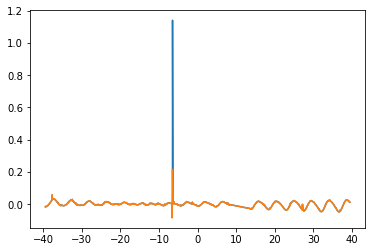

In [78]:
gp_mean = norm_y-flc[1] # mean for GP for total light curve fit is observed light curve - flare light curve
plt.plot(x, norm_y)
plt.plot(x, norm_y-flc[1])
#plt.plot(x, flc[1])
plt.show()

{'index': 393, 'log_power': -9.749128072292478, 'period': 4.457322327027283, 'period_uncert': 0.08707837229068789}


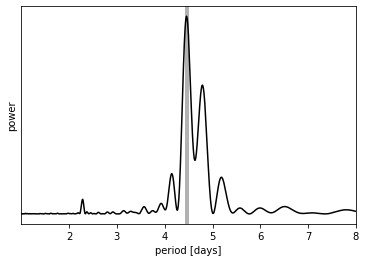

In [79]:
# periodogram
results = xo.estimators.lomb_scargle_estimator(
    x, gp_mean, max_peaks=1, min_period=1.0, max_period=8.0, samples_per_peak=50 # replaced y with gp_mean
)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(1 / freq, power, "k")
plt.axvline(peak["period"], color="k", lw=4, alpha=0.3)
plt.xlim((1 / freq).min(), (1 / freq).max())
plt.yticks([])
plt.xlabel("period [days]")
_ = plt.ylabel("power")
print(peak)

In [66]:
xx = tt.dvector('xx')
tpeaksx = tt.dvector('tpeaksx')
fwhmsx = tt.dvector('fwhmsx')
amplsx = tt.dvector('amplsx')
#texp = 0.001388888888888889
#multiflare = theano.function([xx, tpeaksx, fwhmsx, amplsx],
#                    get_light_curve(xx, tpeaksx, fwhmsx, amplsx, texp=texp))
theano.config.compute_test_value = 'ignore'
multiflare = theano.function([xx, tpeaksx, fwhmsx, amplsx],
                    get_light_curve(xx, tpeaksx, fwhmsx, amplsx))


In [67]:
with pm.Model() as model:
    npeaks = np.shape(tpeaks)[0]
    mean = pm.Normal("mean", mu=0, sd=3.0, testval=0)
    logs2 = pm.Normal("logs2", mu=np.log(np.var(y)), sd=2.0)
    
    tpeak = pm.Normal("tpeak", mu=tpeaks, sd=np.ones_like(tpeaks) * 0.003,
                      testval=tpeaks, shape=npeaks)
    logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms), sd=1.0, testval=np.log(fwhms),
                        shape=npeaks)
    logAmpl = pm.Normal("logAmpl", mu=np.log(ampls), sd=1.0, testval=np.log(ampls),
                        shape=npeaks)
    
    fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
    ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
    
    #flare_lc = get_light_curve(x, tpeak, fwhm, ampl, texp=texp, oversample=15)
    flare_lc = get_light_curve(x, tpeak, fwhm, ampl, oversample=15)
    pm.Deterministic("flare_lc", flare_lc)
    pm.Normal("obs", mu=flare_lc + mean, sd=tt.exp(2*logs2), observed=y)
    
    map_soln = xo.optimize(start=model.test_point, vars=[fwhm, mean])
    map_soln = xo.optimize(start=map_soln, vars=[ampl, mean])
    map_soln = xo.optimize(start=map_soln, vars=[fwhm, ampl])
    map_soln = xo.optimize(start=map_soln, vars=[tpeak])
    
    approx = pm.MeanField(start=map_soln)
    pm.fit(method=pm.KLqp(approx), n=200000,
            obj_optimizer=pm.adagrad_window
        )
    start = approx.sample(draws=4, )
    start = list(start)
    stds = approx.bij.rmap(approx.std.eval())
    cov = model.dict_to_array(stds) ** 2
    potential = quadpotential.QuadPotentialDiag(cov)

optimizing logp for variables: [mean, logFwhm]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -8468708967688.13 -> -8448626363912.203
optimizing logp for variables: [mean, logAmpl]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -8448626363912.203 -> -8448617019698.606
optimizing logp for variables: [logAmpl, logFwhm]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -8448617019698.606 -> -8448617019698.606
optimizing logp for variables: [tpeak]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -8448617019698.606 -> -8448617019698.606


Finished [100%]: Average Loss = -11,311


/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


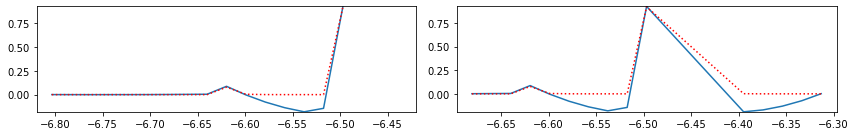

In [73]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
tps = start[0]['tpeak']
for i in range(npeaks):
    timemask = (x >= tps[i]-0.2) * (x < tps[i]+0.2) # true for values within +/- 0.2 of peak indices
    ax = axes[i]
    ax.plot(x[timemask], y[timemask])
    ax.plot(x[timemask], start[0]['flare_lc'][timemask], ':r')
    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
    ax.set_ylim(np.min(y[timemask]), np.max(y[timemask]))
fig.tight_layout()

In [69]:
with model:
    step = pm.NUTS(potential=potential, target_accept=0.9)
    trace = pm.sample(draws=2400, tune=200, step=step, start=start, cores=4)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logAmpl, logFwhm, tpeak, logs2, mean]


Sampling 4 chains for 200 tune and 2_400 draw iterations (800 + 9_600 draws total) took 947 seconds.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


IndexError: index 5 is out of bounds for axis 0 with size 2

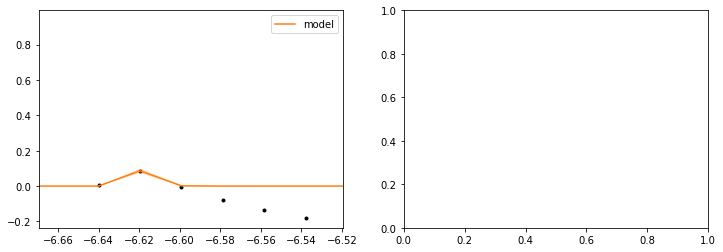

In [70]:
flc =  np.percentile(trace['flare_lc'], [5, 50, 95], axis=0)
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks*2])
axes = axes.flatten()
for i in range(npeaks-1): # cause we double counted one
    timemask = (x >= tpeaks[i]-0.2) & (x < tpeaks[i]+0.2)
    ax = axes[i]
    ax.plot(x[timemask], y[timemask], '.k')
    ax.plot(x[timemask], flc[1][timemask], color="C1", label="model")
    art = ax.fill_between(x[timemask], flc[0][timemask],
                          flc[2][timemask], color="C1", alpha=0.3,
                               zorder=1000)
    art.set_edgecolor("none")
    ax.set_xlim(tpeaks[i]-0.05, tpeaks[i]+0.1)
    #ax.set_ylim(np.min(y[timemask]) - 1, 1 + np.max(y[timemask]))
    ax.legend()

fig.delaxes(axes[5])
fig.tight_layout()

In [ ]:
# for some reason, pymc wants to access trace at index 0 when trace starts at 1...so I cheat to make this work
trace._straces[0] = trace._straces[1]

In [ ]:
# get a smoothed version of the light curve
norm_y = normalize_flux(lc.PDCSAP_FLUX)
norm_yerr = normalize_flux(lc.PDCSAP_FLUX_ERR)
print(norm_y)
print(norm_yerr) # how to deal with errors in normalized time series? 

In [74]:
# okay, I got the period to work out. How about I don't fit every little spike now with my GP? 
# It works!! Hell yeah.
with pm.Model() as model:

    # The mean flux of the time series
    mean = pm.Normal("mean", mu=np.mean(gp_mean), sd=np.std(gp_mean)) # replaced 0.0 and 10.0
    # A jitter term describing excess white noise
    jitter = pm.Lognormal("jitter", mu=np.log(np.mean(norm_yerr)), sd=np.log(np.std(norm_yerr))) # try not logging
    #jitter = pm.Lognormal("jitter", mu=0., sd=np.std(norm_yerr))
    
    # A term to describe the non-periodic variability
    #sigma = pm.InverseGamma(
    #    "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0))
    #rho = pm.InverseGamma(
    #    "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0))
    sigma = pm.InverseGamma(
        "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 2.5))
    rho = pm.InverseGamma(
        "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 1.5))
    
    # The parameters of the RotationTerm kernel
    sigma_rot = pm.InverseGamma(
        "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 2.0)) # formerly Beta param was 5.0, not 2.0
    
    #period = pm.Lognormal("period", mu=np.log(peak["period"]), sd=1.0) 
    period = pm.Normal("period", mu=peak["period"], sd=1.0)  

    #Q0 = pm.Lognormal("Q0", mu=0, sd=2) # or np.log(np.mean(gp_mean))?  
    #dQ = pm.Lognormal("dQ", mu=0, sd=2) # or np.log(np.mean(gp_mean))?
    Q0 = pm.Lognormal("Q0", mu=0, sd=2) # or np.log(np.mean(gp_mean))?  
    dQ = pm.Lognormal("dQ", mu=0, sd=2) # or np.log(np.mean(gp_mean))?
    f = pm.Uniform("f", lower=0.1, upper=1.0)
    
    # Set up the Gaussian Process model
    kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q=1 / 3.0) # tweaking rho and sigma affects whether I'm touch-tight
    kernel += terms.RotationTerm(
        sigma=sigma_rot, period=period, Q0=Q0, dQ=dQ, f=f)
    gp = GaussianProcess(
        kernel, t=x, mean=mean, 
        diag=np.asarray(norm_yerr**2)+jitter**2, quiet=True) # diag = norm_yerr**2 + jitter**2

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=norm_y)

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict(norm_y))

    # Optimize to find the maximum a posteriori parameters
    map_soln = pmx.optimize()

optimizing logp for variables: [f, dQ, Q0, period, sigma_rot, rho, sigma, jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 2830.2181504321493 -> 13875.256885852223


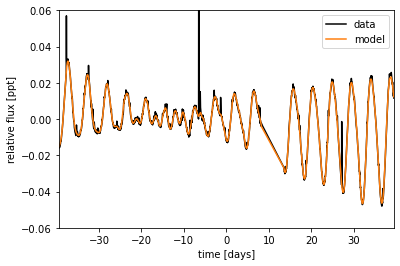

In [87]:
# plot maximum a posteriori model prediction

plt.plot(x, norm_y, "k", label="data")
plt.plot(x, map_soln["pred"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.ylim(-0.06, 0.06)
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
#_ = plt.title("pyMC model of EPIC 246301900 light curve")
plt.savefig('quiescent_gp.png')
plt.show()

In [80]:
# sample from posterior
np.random.seed(10863087)
with model:
    trace = pmx.sample(
        tune=2500,
        draws=2500,
        start=map_soln,
        cores=2,
        chains=2,
        target_accept=0.95,
    )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f, dQ, Q0, period, sigma_rot, rho, sigma, jitter, mean]


Sampling 2 chains for 2_500 tune and 2_500 draw iterations (5_000 + 5_000 draws total) took 438 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [81]:
with model:
    summary = pm.summary(
        trace,
        var_names=[
            "f",
            "dQ",
            "Q0",
            "period",
            "sigma_rot",
            "rho",
            "sigma",
            "jitter",
            "mean",
        ],
    )
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
f,0.229,0.144,0.100,0.511,0.003,0.002,2839.0,2839.0,2086.0,2305.0,1.0
dQ,6.751,30.742,0.001,21.509,0.488,0.345,3974.0,3974.0,6052.0,3006.0,1.0
Q0,496450.725,203857.047,190001.226,884796.408,4280.721,3324.400,2268.0,1881.0,2961.0,2438.0,1.0
period,4.565,0.032,4.508,4.627,0.000,0.000,5491.0,5491.0,5637.0,3063.0,1.0
sigma_rot,1.140,0.149,0.870,1.423,0.002,0.001,5870.0,5542.0,6162.0,3784.0,1.0
rho,1127.272,521.458,206.846,1969.750,13.790,9.753,1430.0,1430.0,1235.0,1055.0,1.0
sigma,1.006,0.162,0.728,1.329,0.002,0.002,4804.0,4384.0,5256.0,3247.0,1.0
jitter,0.000,0.000,0.000,0.000,0.000,0.000,5292.0,5292.0,5269.0,2978.0,1.0
mean,-0.004,0.022,-0.047,0.035,0.000,0.000,6511.0,2307.0,6542.0,3589.0,1.0


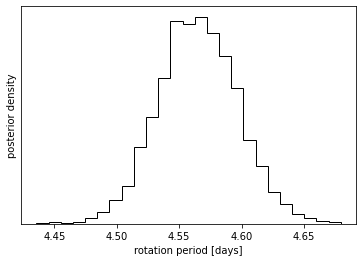

In [82]:
period_samples = trace["period"]
plt.hist(period_samples, 25, histtype="step", color="k", density=True)
plt.yticks([])
plt.xlabel("rotation period [days]")
_ = plt.ylabel("posterior density")
plt.savefig("period_posterior_gp.png")

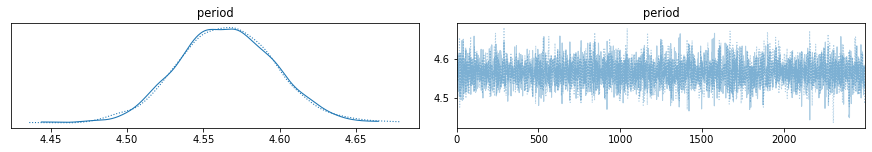

In [83]:
# show burn-in
import arviz as az

with model:
    az.plot_trace(trace, var_names=["period"])
plt.savefig("period_trace_gp.png")